# Performance Evaluation

This notebook performs performance evaluation for the data set provided by [tia16].

REFERENCES
- [tia16] Tian et al. Performance evaluation of automated segmentation software on optical coherence tomography volume data. J. Biophotonics, 2016.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import h5py

import sys, time
from datetime import datetime
import numpy as np
import pylab as plt
from scipy.io import loadmat, savemat

## Load Data

In [2]:
# This is the original ground truth from [tia16]
tian_data = '/Users/pekalmj1/Data/Tian_OCT/jbio201500239-sup-0003-Data-S1.mat'
boundaries_of_interest = np.array([0, 1, 2, 4, 7])  # TODO: paper says 1, 2, 4, 6, 11!
#boundaries_of_interest = np.array([1,2,4,6,11]) - 1

f = loadmat(tian_data)
print(f.keys())

Y_true = np.transpose(f['O1'], [2, 0, 1])
print(Y_true.shape)
Y_true = Y_true[:, boundaries_of_interest, :]

Y_IOWA = np.transpose(f['IOWA'], [1, 2, 0])
X = np.transpose(f['volumedata'], [2,0,1])


# TODO TODO
# Do all train/test folds so we can evaluate the entire data set here!
# TODO TODO
test_images = np.arange(0,50,step=5)
Y_true = Y_true[test_images, ...]
Y_IOWA = Y_IOWA[test_images, ...]
X = X[test_images, ...]


# These are our post-processed semantic segmentation results
f = loadmat("final_estimates.mat")
print(f.keys())
Y_hat = f['Y_hat']

print(X.shape, Y_true.shape, Y_IOWA.shape, Y_hat.shape)

dict_keys(['O2', 'volumedata', 'Bern', 'AURA', 'OCTRIMA', '__globals__', '__header__', '__version__', 'O1', 'Spectralis', 'IOWA'])
(50, 9, 768)
dict_keys(['__globals__', '__header__', '__version__', 'Y_hat'])
(10, 496, 768) (10, 5, 768) (10, 5, 768) (10, 5, 768)


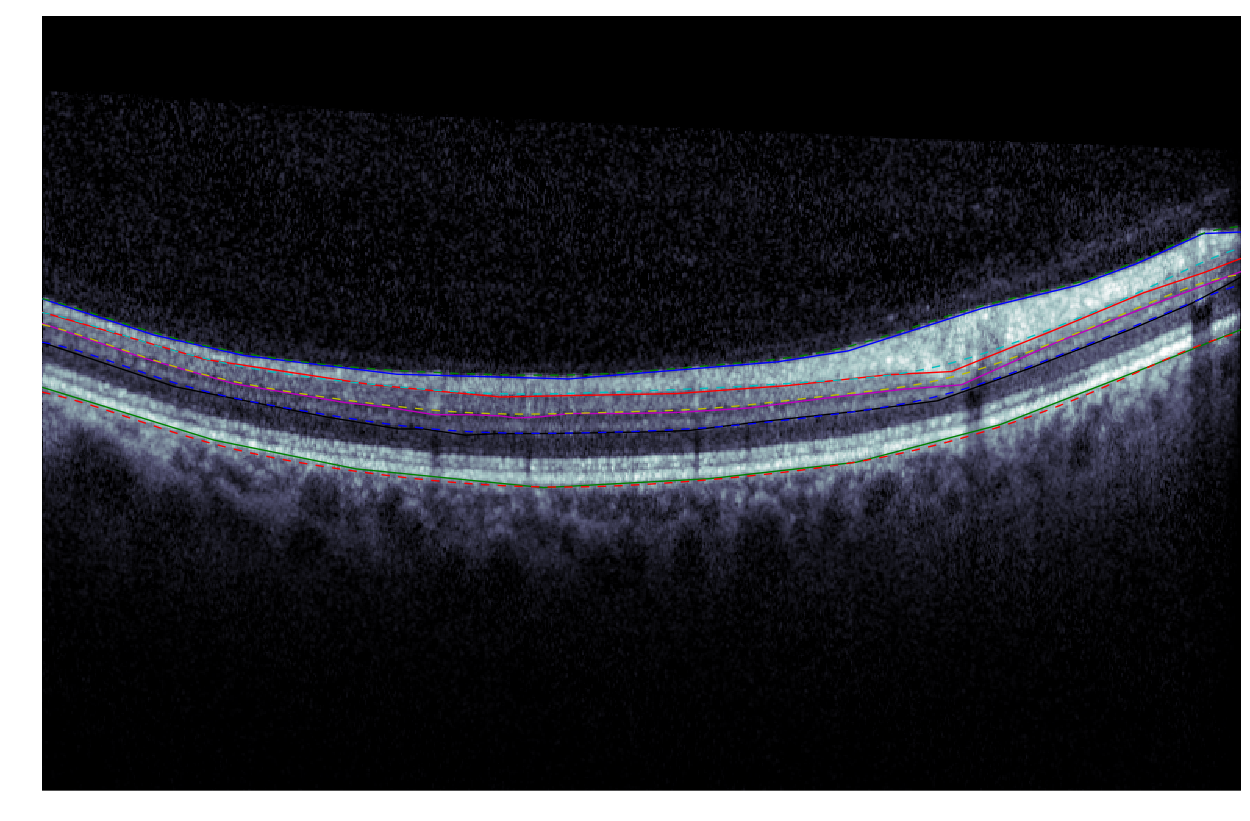

In [3]:
# Take a quick look at the data
img_idx = 1

plt.figure(figsize=(20,10))
plt.imshow(X[img_idx,...], interpolation='none', cmap='bone')

x_vals = np.arange(Y_true.shape[-1])

for boundary_id in range(Y_true.shape[1]):
    plt.plot(x_vals, Y_true[img_idx, boundary_id, :], '-')
    plt.plot(x_vals, Y_hat[img_idx, boundary_id, :], '--')

plt.axis('off')
plt.xlim([0, np.max(x_vals)])
plt.ylim([0, X.shape[1]])
plt.gca().invert_yaxis()

## Augmenting Figure 3  of [tia16]

mean absolute error CNN:  2.085
   boundary 0:    2.78  (2.000)
   boundary 1:    1.84  (2.215)
   boundary 2:    1.81  (1.629)
   boundary 3:    1.51  (1.921)
   boundary 4:    2.48  (4.648)

mean absolute error IOWA WARNING POSSIBLE BOUNDARY MISMATCH:  2.427
   boundary 0:    3.16  (13.313)
   boundary 1:    2.29  (4.506)
   boundary 2:    2.44  (5.058)
   boundary 3:    2.11  (5.513)
   boundary 4:    2.14  (7.276)


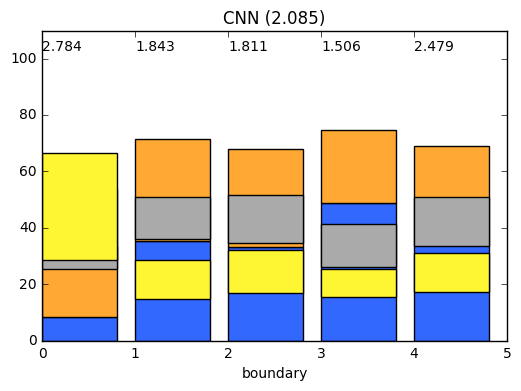

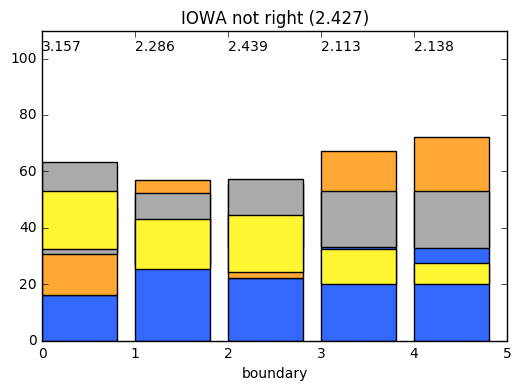

In [4]:
def print_err(errors, who):
    err_l1 = np.abs(errors)
    print('mean absolute error %s:  %0.3f' % (who, np.mean(err_l1)))
    for b_id in range(errors.shape[1]):
        print('   boundary %d:' % b_id, end='    ')
        print('%0.2f' % (np.mean(err_l1[:, b_id, :])), end='  ')
        print('(%0.3f)' % (np.std(err_l1[:, b_id, :])))
        
def plot_l1_hist(errors, who):
    # TODO: make sure this matches the paper!!!
    err_l1 = np.abs(errors)
    width=.8

    for b_id in range(err_l1.shape[1]):
        n_0_1 = np.sum(err_l1[:,b_id,:] < 1)
        n_1_2 = np.sum(err_l1[:,b_id,:] < 2) - n_0_1
        n_2_3 = np.sum(err_l1[:,b_id,:] < 3) - n_1_2 - n_0_1
        n_3_inf = np.sum(err_l1[:,b_id,:] >= 3)
        mu = np.mean(err_l1[:,b_id,:])
            
        n = err_l1[:,b_id,:].size
        n_0_1 /= n/100.
        n_1_2 /= n/100.
        n_2_3 /= n/100.
        n_3_inf /= n/100.

        plt.bar(b_id, n_0_1, width, color='#3368ff')
        plt.bar(b_id, n_1_2, width, bottom=n_0_1, color='#ffa833')
        plt.bar(b_id, n_2_3, width, bottom=n_0_1+n_1_2, color='#aaaaaa')
        plt.bar(b_id, n_3_inf, width, bottom=n_2_3, color='#fff633')
        plt.gca().annotate('%0.3f' % mu, xy=(b_id,103))
    
    mu = np.mean(err_l1)
    plt.xlabel('boundary')
    plt.ylim([0,110])
    plt.title('%s (%0.3f)' % (who, mu))
        

err_cnn = (Y_true - Y_hat)
err_iowa = (Y_true - Y_IOWA)

print_err(err_cnn, 'CNN')
plt.figure()
plot_l1_hist(err_cnn, 'CNN')

print('')
print_err(err_iowa, 'IOWA WARNING POSSIBLE BOUNDARY MISMATCH')
plt.figure()
plot_l1_hist(err_iowa, 'IOWA not right')

plt.show()